In [2]:
from os.path import dirname, abspath,join
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from typing import List
import re, os, json
import seaborn as sns
from os import makedirs

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from proT.evaluation.predict import *
from proT.evaluation.metrics import compute_prediction_metrics


# plotting standard settings
plt.rcParams['figure.dpi'] = 100 #360 # standard is 360 but for set to 100 for practical visualization on the notebook
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['lines.linewidth'] = 1.5

S6 Mamba backend: mamba-pytorch (pure PyTorch fallback)


## Lib

In [59]:
from torchmetrics.regression import R2Score, MeanSquaredError, MeanAbsoluteError

@torch.no_grad()
def eval_df_torchmetrics(
    y_pred: torch.Tensor,          # (B, S, D)
    y_true: torch.Tensor,          # (B, S, D)
    mask: torch.Tensor | None = None,  # (B, S) bool, True = valid
    feature_names: list[str] | None = None,
) -> pd.DataFrame:
    
    if not isinstance(y_pred, torch.Tensor):
        print("Converted output to torch tensor")
        y_pred = torch.tensor(y_pred)
        
    if not isinstance(y_true, torch.Tensor):
        print("Converted target to torch tensor")
        y_true = torch.tensor(y_true)
    
    if y_pred.shape != y_true.shape or y_true.ndim != 3:
        print(f"Found output shape {y_pred.shape} and target shape {y_true.shape}")
        raise ValueError("Expected matching (B,S,D) tensors.")
    B, S, D = y_true.shape
    device = y_true.device

    if feature_names is not None and len(feature_names) != D:
        raise ValueError(f"feature_names length {len(feature_names)} must equal D={D}")
    
    if D > 1:
        labels = feature_names or [f"f{d}" for d in range(D)]
    else:
        labels = None

    # Per-sample metrics (over S), returned per-feature (D)
    r2_metric  = lambda: R2Score(multioutput="raw_values").to(device)
    mse_metric = lambda: MeanSquaredError().to(device)
    mae_metric = lambda: MeanAbsoluteError().to(device)

    rows = []
    has_mask = mask is not None
    if has_mask:
        if mask.shape != (B, S):
            raise ValueError(f"mask must be (B,S); got {mask.shape}")

    for b in range(B):
        idx = mask[b] if has_mask else slice(None)
        yt = y_true[b, idx, :]   # (S_b, D)
        yp = y_pred[b, idx, :]   # (S_b, D)

        if yt.numel() == 0:  # no valid steps → fill zeros
            r2 = torch.zeros(D, device=device)
            mse = torch.zeros(D, device=device)
            mae = torch.zeros(D, device=device)
        else:
            r2  = r2_metric()(yp, yt)   # (D,)
            mse = mse_metric()(yp, yt)  # (D,)
            mae = mae_metric()(yp, yt)  # (D,)

        r2  = r2.detach().cpu().tolist()
        mse = mse.detach().cpu().tolist()
        mae = mae.detach().cpu().tolist()

        if D > 1 and labels is not None:
            for d, name in enumerate(labels):
                rows.append({"index": b, "feature": name, "R2": r2[d], "MSE": mse[d], "MAE": mae[d]})
        else:
            rows.append({"index": b, "R2": r2, "MSE": mse, "MAE": mae})

    return pd.DataFrame(rows)


def plot_predictions(
    sample_id: int, var_index: int, x_index: int, val_index: int, target_array: np.ndarray, 
    output_array: np.ndarray, title_map: dict=None, 
    save_dir: str=None, tag: str=None):
    
    vars = np.unique(target_array[:,:,var_index])
    vars = vars[~np.isnan(vars)]
    num_vars = len(vars)
    
    fig = plt.figure(figsize=(6*num_vars, 6))
    gs = gridspec.GridSpec(1, num_vars, wspace=0.3)

    
    if len(output_array.shape) > 2:
        value = output_array[:,:,0].copy()
    else:
        value = output_array.copy()
    
    target = target_array.copy()
    
    # de-normalize
    value *= 10
    target[:, :, val_index] *= 10
    
    # get min and max value for xaxis_lim
    c = np.concatenate([value[sample_id],target[sample_id, :, val_index]])
    d = c[~(np.isnan(c))]
    min_val = np.min(d)
    max_val = np.max(d)
    
    for i,var in enumerate(vars):
        var_mask = target[sample_id, :, var_index] == var
        x = target[sample_id, :, x_index][var_mask]
        y_out = value[sample_id][var_mask]
        y_trg = target[sample_id, :, val_index][var_mask]
        ax = fig.add_subplot(gs[i])
        ax.plot(x, y_out, label="prediction")
        ax.plot(x, y_trg, label="target")
        ax.set_ylabel(r"$\Delta R [\%]$")
        ax.set_xlabel("Position")
        ax.set_xlim(0,x[~np.isnan(x)][-1])
        ax.set_ylim(min_val, max_val)
        
        # add metrics
        mask = torch.logical_not(torch.tensor(target[sample_id,:,val_index][var_mask]).isnan())
        df_met = eval_df_torchmetrics(
            y_pred=torch.tensor(y_out).unsqueeze(0).unsqueeze(-1), 
            y_true=torch.tensor(y_trg).unsqueeze(0).unsqueeze(-1), mask=mask.unsqueeze(0))
        mae = df_met.loc[0,"MAE"]
        r2 = df_met.loc[0,"R2"]
        
        title = (title_map[var]) if title_map is not None else var
        
        ax.set_title(f"{title}: MAE={mae:.2f}, R2={r2:.2f}")
        ax.legend()
    
    # optional export
    filename = f"prediction_sample_{sample_id}_{tag}.pdf"
    if save_dir is not None:
        makedirs(save_dir, exist_ok=True)
        out_path = join(save_dir, filename)
        fig.savefig(out_path, format="pdf", bbox_inches="tight")
    
    plt.show()

## Src

In [60]:
datadir_path    = r"../data/input"
experiment_path     = r"../experiments/baseline_optuna/euler/baseline_proT_dyconex_sum_50191158"

def get_config_and_best_checkpoint(exp_path):
    
    # get config
    config_regex = re.compile("config")
    best_trial_regex = re.compile("best_trial")
    
    config_list = []
    summary_list = []
    for file in os.listdir(exp_path):
        
        if config_regex.match(file):
            config_list.append(file)
                
        elif best_trial_regex.match(file):
            summary_list.append(file)
    
    if len(config_list) != 1:
        raise ValueError(f"More (or none) than one config found! {config_list}")
    else:
        config = OmegaConf.load(os.path.join(exp_path, config_list[0]))
    if len(summary_list) != 1:
        raise ValueError(f"More (or none) than one config found! {summary_list}")
    else:
        summary = OmegaConf.load(os.path.join(exp_path, summary_list[0]))
        
    # get BCE (best checkpoint ever ^^)
    optuna_dir = os.path.join(exp_path, "optuna")
    assert os.path.exists(optuna_dir), AssertionError("Optuna folder doesn't exixt!")
    
    run_dir = os.path.join(optuna_dir, f"run_{summary.trial_number}")
    
    with open(os.path.join(run_dir, "kfold_summary.json")) as f:
        kfold_summary = json.load(f)
    
    
    best_checkpoint_path = os.path.join(
        run_dir,
        f"k_{kfold_summary["best_fold"]["fold_number"]}",
        "checkpoints",
        "best_checkpoint.ckpt"
    )
        
        
    return config, best_checkpoint_path

In [61]:
config, checkpoint_path = get_config_and_best_checkpoint(experiment_path)

results = predict_test_from_ckpt(
    config, 
    datadir_path, 
    checkpoint_path, 
    None,
    dataset_label="test",
    cluster=False
    )

Seed set to 42


No Causal mask found!
Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Test dataset selected.
Predicting...


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


In [62]:
groups = results.inputs[:,0,0]

df_ds_metrics = pd.read_parquet("../../proT_pipeline/data/builds/dyconex_251117/output/sample_metrics.parquet")
df_metrics = compute_prediction_metrics(results, target_feature_idx=config.data.features.Y.value)
df_metrics["group"] = groups

df = df_metrics.merge(df_ds_metrics, on= "group", how="left")
df["rarity_nan_fraction_target"] += 0.02* np.random.randn(len(df))
df["rarity_last_value"] += 0.02* np.random.randn(len(df))
df

,index,R2,MSE,MAE,RMSE,group,rarity_last_value,rarity_nan_fraction_input,rarity_nan_fraction_target
0,0,0.865871,0.004451,0.045867,0.066717,877.0,0.022411,0.000000,0.009934
1,1,0.758849,0.003015,0.047146,0.054908,315.0,0.003008,0.000801,-0.002765
2,2,0.646211,0.005457,0.070206,0.073874,459.0,0.006960,0.000801,0.012954
3,3,0.628915,0.006561,0.073812,0.080998,704.0,0.037648,0.000801,0.030461
4,4,0.893762,0.002655,0.043633,0.051523,835.0,0.019133,0.000000,-0.004683
...,...,...,...,...,...,...,...,...,...
379,379,0.864876,0.002034,0.040175,0.045095,1224.0,-0.000721,0.000801,-0.016166
380,380,0.727560,0.007379,0.076059,0.085902,1169.0,0.032509,0.000000,-0.016794
381,381,0.866763,0.002119,0.038758,0.046029,1394.0,-0.003889,0.007163,-0.011988
382,382,-0.242880,0.008425,0.086509,0.091787,1888.0,0.009814,0.000801,-0.042478


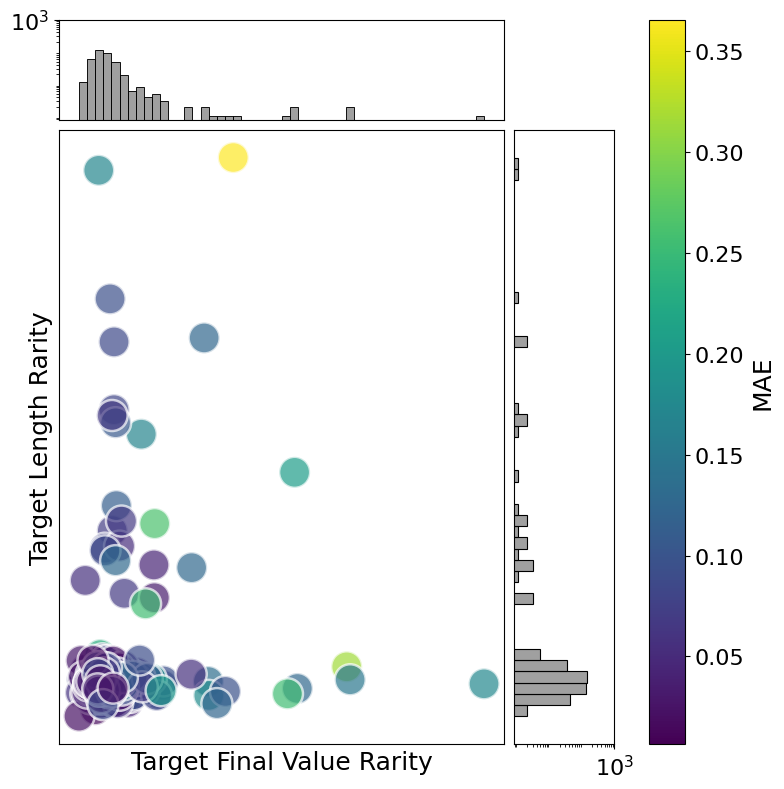

In [63]:

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

# Main scatterplot
sc = sns.scatterplot(
    data=df,
    x="rarity_last_value",
    y="rarity_nan_fraction_target",
    hue="MAE",
    s=500,
    palette="viridis",
    ax=ax,
    legend=False,
    alpha=0.7
)

ax.set_ylabel("Target Length Rarity")
ax.set_xlabel("Target Final Value Rarity")


# Create a ScalarMappable for the colorbar
norm = plt.Normalize(df["MAE"].min(), df["MAE"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("MAE")

# Add marginal histograms
divider = make_axes_locatable(ax)
ax_marg_x = divider.append_axes("top", 1.0, pad=0.1, sharex=ax)
ax_marg_y = divider.append_axes("right", 1.0, pad=0.1, sharey=ax)

# Plot x marginal
sns.histplot(data=df, x="rarity_last_value", ax=ax_marg_x, color="gray", bins=50)
ax_marg_x.set_yscale("log")
ax_marg_x.set_xticks([])
ax_marg_x.set_yticks([1E3])
ax_marg_x.set_xlabel("")
ax_marg_x.set_ylabel("")


# Plot y marginal
sns.histplot(data=df, y="rarity_nan_fraction_target", ax=ax_marg_y, color="gray", bins=50)
ax_marg_y.set_xscale("log")
ax_marg_y.set_ylabel("")
ax_marg_y.set_xticks([1E3])
ax_marg_y.set_yticks([])
ax_marg_y.set_xlabel("")
ax_marg_y.set_ylabel("")

plt.tight_layout()
plt.show()

In [64]:
sorted_idx_df = df.sort_values(by="MAE", ascending=False).index
print("Total test samples: {len(sorted_idx_df)}")

Total test samples: {len(sorted_idx_df)}


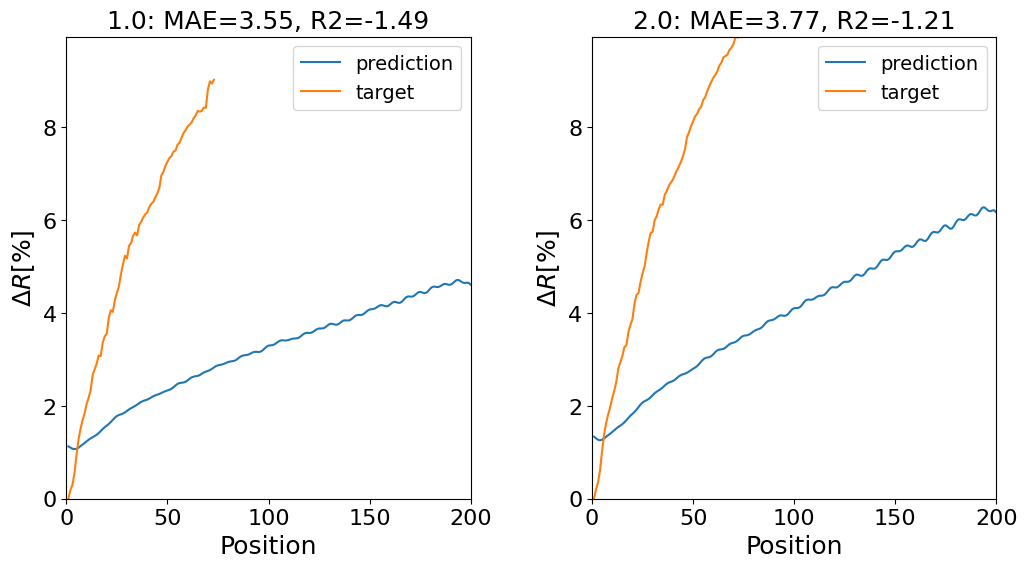

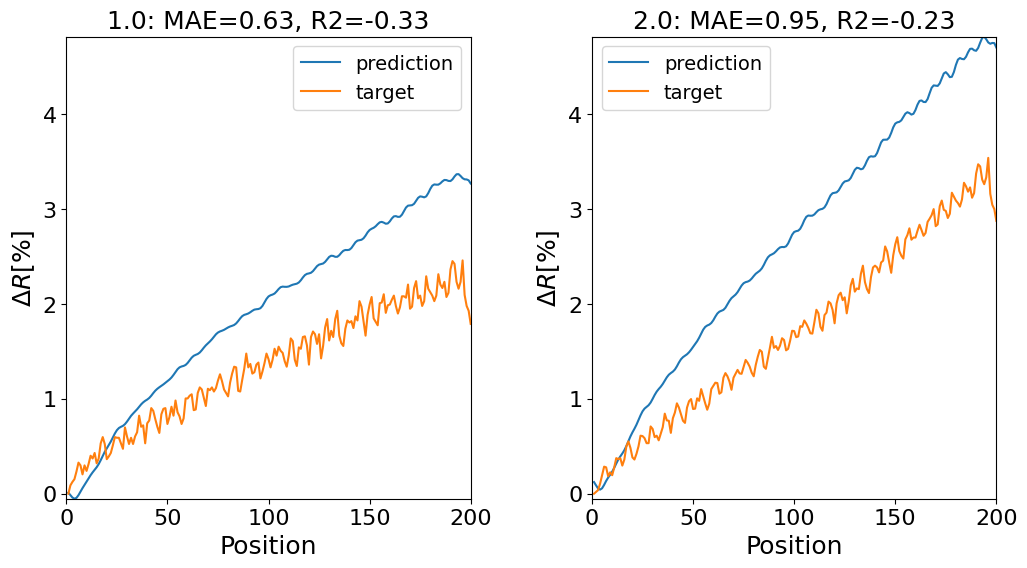

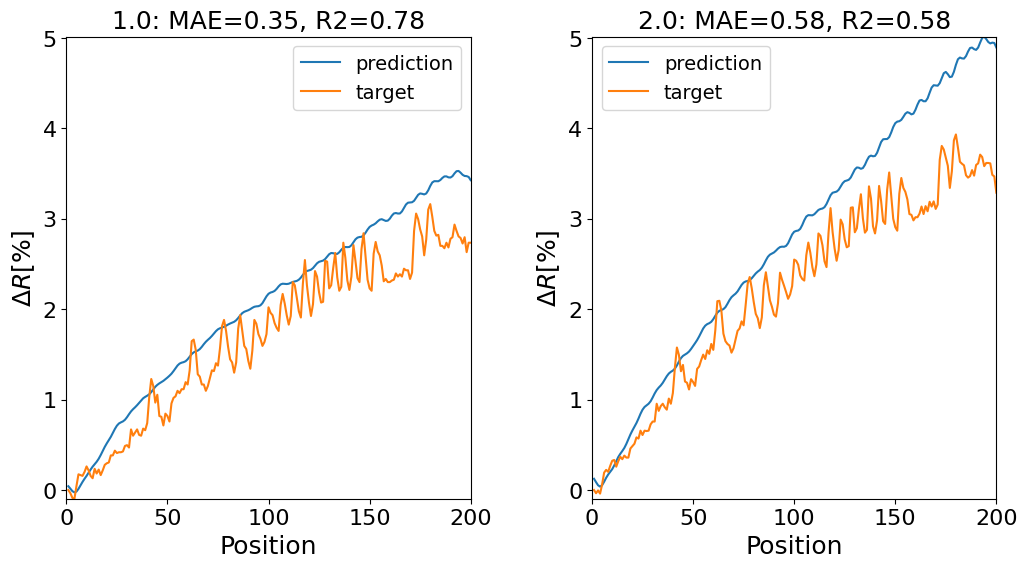

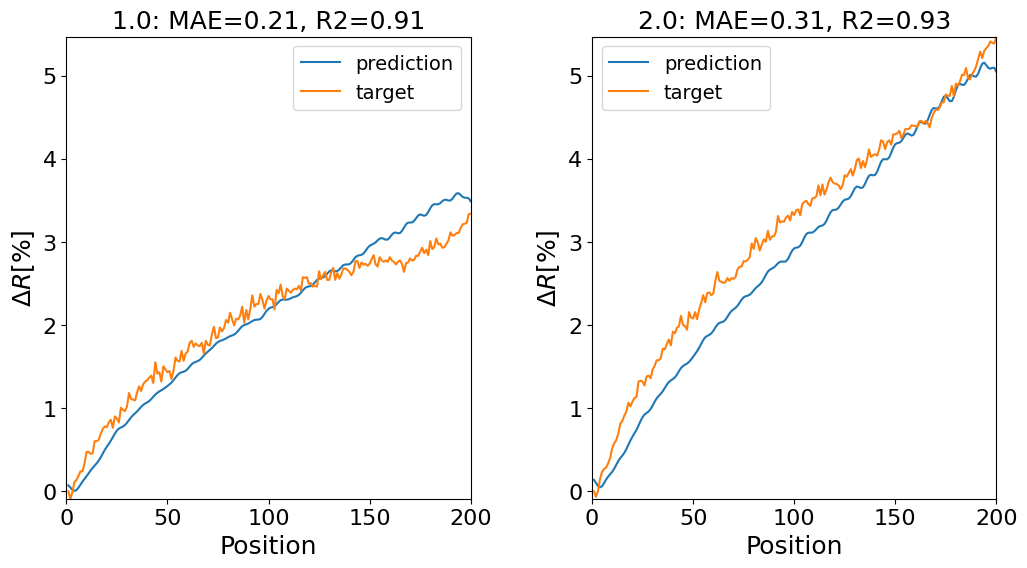

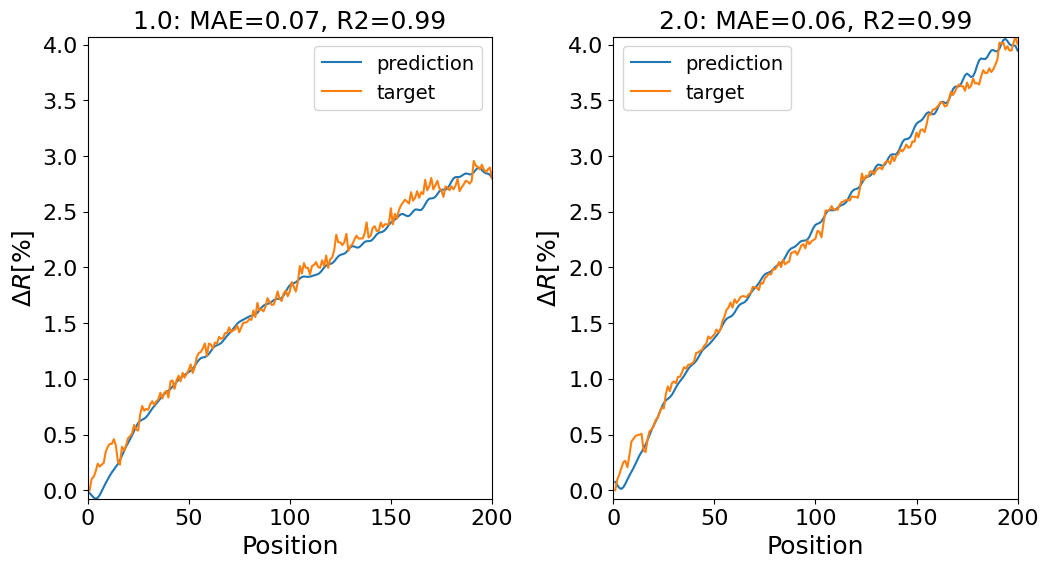

In [65]:
plot_predictions(
    sample_id=sorted_idx_df[0], var_index=config.data.features.Y.variable, x_index=config.data.features.Y.position, val_index=config.data.features.Y.value, target_array=results.targets, 
    output_array=results.outputs, title_map=None, 
    save_dir=None, tag=None)

plot_predictions(
    sample_id=sorted_idx_df[100], var_index=config.data.features.Y.variable, x_index=config.data.features.Y.position, val_index=config.data.features.Y.value, target_array=results.targets, 
    output_array=results.outputs, title_map=None, 
    save_dir=None, tag=None)

plot_predictions(
    sample_id=sorted_idx_df[200], var_index=config.data.features.Y.variable, x_index=config.data.features.Y.position, val_index=config.data.features.Y.value, target_array=results.targets, 
    output_array=results.outputs, title_map=None, 
    save_dir=None, tag=None)

plot_predictions(
    sample_id=sorted_idx_df[300], var_index=config.data.features.Y.variable, x_index=config.data.features.Y.position, val_index=config.data.features.Y.value, target_array=results.targets, 
    output_array=results.outputs, title_map=None, 
    save_dir=None, tag=None)


plot_predictions(
    sample_id=sorted_idx_df[-1], var_index=config.data.features.Y.variable, x_index=config.data.features.Y.position, val_index=config.data.features.Y.value, target_array=results.targets, 
    output_array=results.outputs, title_map=None, 
    save_dir=None, tag=None)